## FIT5201 - Machine Learning Assessment 2 - Question 3

- Student Name : Keerthana Muralitharan
- Student ID : 30159474

### Question 3 [Self Taught Neural Network Learning, 30 Marks]

##### Importing the libraries and packages

Import the necessary packages for the processing.


**Note** - based on the different epoch values and initial weight values we would get different results.Below analysis is made on one particular set of values.

In [ ]:
#http://h2o-release.s3.amazonaws.com/h2o/rel-zahradnik/4/index.html

# The following two commands remove any previously installed H2O packages for R.
if ("package:h2o" %in% search()) { detach("package:h2o", unload=TRUE) }
if ("h2o" %in% rownames(installed.packages())) { remove.packages("h2o") }

# Next, we download packages that H2O depends on.
pkgs <- c("RCurl","jsonlite")
for (pkg in pkgs) {
if (! (pkg %in% rownames(installed.packages()))) { install.packages(pkg) }
}

# Now we download, install and initialize the H2O package for R.
install.packages("h2o")

In [1]:
# Finally, let's load H2O and start up an H2O cluster
library(h2o)
library(ggplot2)
require(reshape2)
#https://groups.google.com/forum/#!topic/h2ostream/3vBMiIOhOVs
#Sys.setenv(JAVA_HOME = "C:/Program Files/Java/jdk1.8.0_251")
#print(Sys.getenv("JAVA_HOME"))

h2o.init(strict_version_check = FALSE)

options(warn=-1)
#If there is a proxy: proxy.old <- Sys.getenv('http_proxy'); Sys.setenv('http_proxy'='');
localH2O =  h2o.init(nthreads = -1, port = 54321, startH2O = FALSE)



----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: 'h2o'


The following objects are masked from 'package:stats':

    cor, sd, var


The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc


Loading required package: reshape2




H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\KEERTH~1\AppData\Local\Temp\RtmpQnpX2y/h2o_Keerthana_started_from_r.out
    C:\Users\KEERTH~1\AppData\Local\Temp\RtmpQnpX2y/h2o_Keerthana_started_from_r.err


Starting H2O JVM and connecting: . Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         5 seconds 437 milliseconds 
    H2O cluster timezone:       Australia/Sydney 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.22.1.1 
    H2O cluster version age:    1 year, 5 months and 14 days !!! 
    H2O cluster name:           H2O_started_from_R_Keerthana_lnj689 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.74 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    

Warning message in h2o.clusterInfo():
"
Your H2O cluster version is too old (1 year, 5 months and 14 days)!
Please download and install the latest version from http://h2o.ai/download/"



 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         5 seconds 660 milliseconds 
    H2O cluster timezone:       Australia/Sydney 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.22.1.1 
    H2O cluster version age:    1 year, 5 months and 14 days !!! 
    H2O cluster name:           H2O_started_from_R_Keerthana_lnj689 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.74 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.5.3 (2019-03-11) 



#### I. Load Task2C_labeled.csv, Task2C_unlabeled.csv and Task2C_test.csv data sets and required libraries (e.g., H2O). Note that we are going to use Task2C_labeled.csv and Task2C_unlabeled.csv for training the autoencoder. We are going to use Task2C_labeled.csv for training the classifier. Finally, we evaluate the trained classifier on the test Task2C_test.csv.

In [2]:
# Students: Use the "absolute" path to the datasets on your machine (important)
labeled.frame <- h2o.importFile(path = 'C:/Users/Keerthana/Desktop/FIT5201/Assignment 2/Task2C_labeled.csv' ,sep=',') 
unlabeled.frame <- h2o.importFile(path = 'C:/Users/Keerthana/Desktop/FIT5201/Assignment 2/Task2C_unlabeled.csv' ,sep=',') 
test.frame <- h2o.importFile(path = 'C:/Users/Keerthana/Desktop/FIT5201/Assignment 2/Task2C_test.csv' ,sep=',') 

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [3]:
#nitialising the frames
labeled.frame[,1] <- as.factor(labeled.frame$label)
unlabeled.frame[,1] <- NA

#bind the two frames.
train.frame <- h2o.rbind(labeled.frame[,-1], unlabeled.frame[,-1])
test.frame[,1] <- as.factor(test.frame$label)

In [4]:
#Create matrices
reconstruction.test.error <- matrix(NA, nrow=20, ncol=1)
classification.test.error <- matrix(NA, nrow=20, ncol=1)
self.test.error <- matrix(NA, nrow=20, ncol=1)

In [5]:
#Calculate the error rates.
error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}


#### II.Train an autoencoder (similar to Activity 5.2) with only one hidden layer and change the number of its neurons to: 20, 40, 60, 80, …, 400 (i.e. from 20 to 400 with a step size of 20).

In [6]:
# build a neural network classifier based on the labeled training data
My_model <- function(k,combined_frame){

NN.model_rec <- h2o.deeplearning(    
  x = 2:ncol(combined_frame), # select all pixels + extra features
  training_frame = combined_frame, # specify the frame (imported file)    
  hidden = c(k), # number of layers and their units
  epochs = 45, # maximum number of epoches  
  activation = 'Tanh', # activation function 
  autoencoder = TRUE, # is it an autoencoder? Yes!
  l2 = 0.1
)
    
#https://www.rdocumentation.org/packages/h2o/versions/3.30.0.1/topics/h2o.anomaly
#Detect anomalies in an H2O dataset using an H2O deep learning model with auto-encoding.
reconstruction_error<-h2o.anomaly(NN.model_rec, combined_frame, per_feature = FALSE)    
    
return(mean(reconstruction_error))
}

#### III. For each model in Step II, calculate and record the reconstruction error which is simply the average (over all data points while the model is fixed) of Euclidian distances between the input and output of the autoencoder (you can simply use “h2o.anomaly()” function). Plot these values where the x-axis is the number of units in the middle layer and the y-axis is the reconstruction error. Then, save and attach the plot to your PDF report. Explain your findings based on the plot in your PDF report.

In [7]:
i=1
for (k in seq(20, 400, 20)){
  if (i<=nrow(reconstruction.test.error)){
  #store the reconstruction error and store for all k values.
  reconstruction.test.error[i,1]<-My_model(k,train.frame)
  i=i+1}
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

In [8]:
MatrixC <- cbind(reconstruction.test.error, c(seq(20,400,20)))  
Reconstruction_test_error<-as.data.frame((MatrixC))
col_headings <- c('Error','K')
names(Reconstruction_test_error) <- col_headings

In [9]:
Reconstruction_test_error

Error,K
0.016905605,20
0.008122241,40
0.045066474,60
0.004698050,80
0.003916243,100
0.050804491,120
0.004133422,140
0.004968323,160
0.003941535,180
0.004147316,200


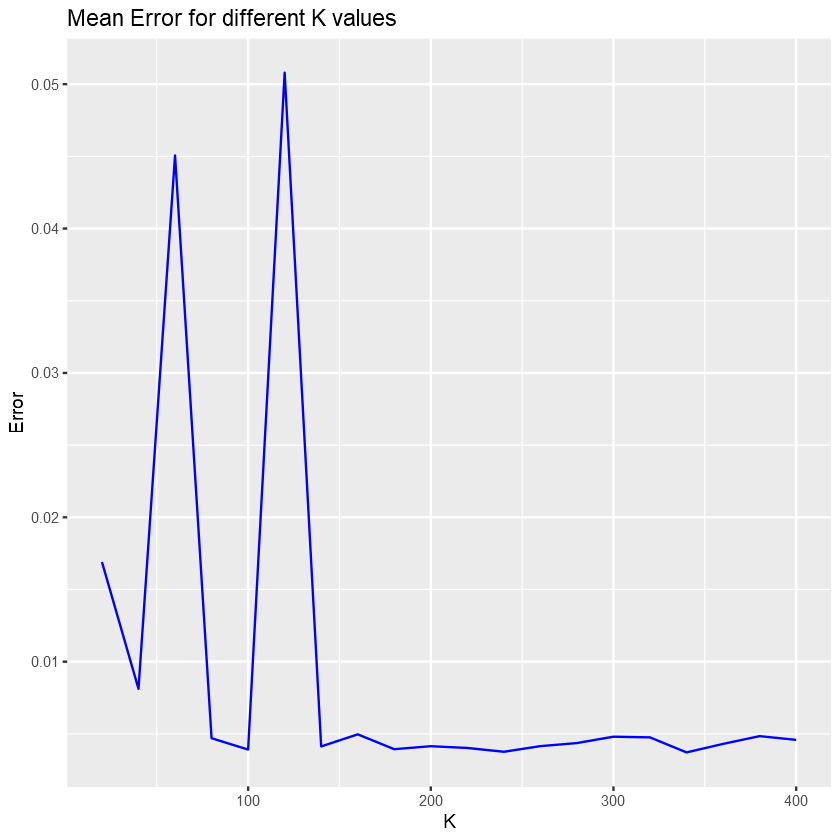

In [10]:
#plotting the reconstruction error
ggplot(data=Reconstruction_test_error, aes(x=K, y=Error)) + geom_line(color='blue') + ggtitle("Mean Error for different K values")

**Inference** : we could see a decrease in the error rates as the K values increases with a considerable fluctuations and it remains the same with less number of fluctuations towards higher values of K, but it goes to convergence.

#### IV. Build the 3-layer NN from Activity 5.1 or “h2o.deeplearning” function (make sure you set “ autoencoder = FALSE”) to build a classification model using all the original attributes from the training set and change the number of its neurons to: 20, 40, 60, 80, .., 400 like Step II. For each model, calculate and record the test error.

In [11]:
# build a neural network classifier based on the labeled training data
class_model <- function(k,labeled.frame){

NN.model_class <- h2o.deeplearning(    
  x = 2:ncol(labeled.frame), # select all pixels + extra features
    y=1,
  training_frame = labeled.frame, # specify the frame (imported file)    
  hidden = c(k), # number of layers and their units
  epochs = 50, # maximum number of epoches  
  activation = 'Tanh', # activation function 
  autoencoder = FALSE, # is it an autoencoder? Yes!
  l2 = 0.1
)
    
#https://www.rdocumentation.org/packages/h2o/versions/3.30.0.1/topics/h2o.anomaly
#Detect anomalies in an H2O dataset using an H2O deep learning model with auto-encoding. 
test.predict <- h2o.predict(NN.model_class, test.frame)$predict
classification_error=error.rate(test.predict,test.frame$label)
    
return(classification_error)
}

In [12]:
i=1
for (k in seq(20, 400, 20)){
  if (i<=nrow(classification.test.error)){
  #Calculate the classification test error
  classification.test.error[i,1]<-class_model(k,labeled.frame)
  i=i+1}
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

In [13]:
MatrixC <- cbind(classification.test.error, c(seq(20,400,20)))  
Classification_test_error<-as.data.frame((MatrixC))
col_headings <- c('Error_class','K')
names(Classification_test_error) <- col_headings

In [14]:
Classification_test_error

Error_class,K
0.334,20
0.577,40
0.560,60
0.607,80
0.538,100
0.528,120
0.543,140
0.552,160
0.513,180
0.516,200


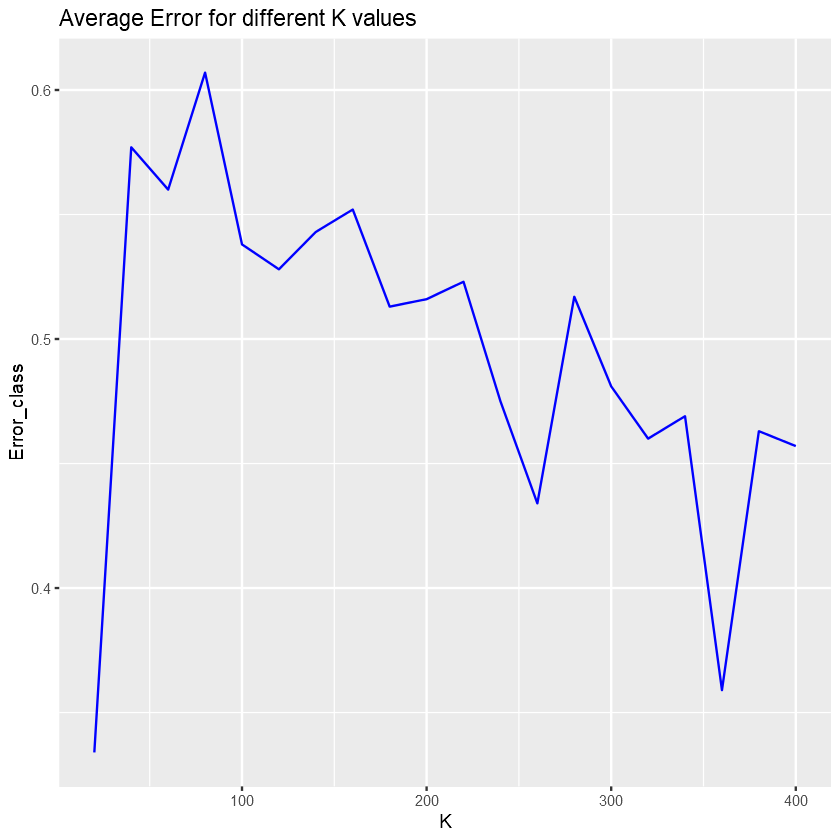

In [15]:
#plotting the classfifcation error
ggplot(data=Classification_test_error, aes(x=K, y=Error_class)) + geom_line(color='blue') + ggtitle("Average Error for different K values")

**Inference** : we could see a decrease in the error rates as the classification as the K values increases with a considerable fluctuations.

#### V. Build augmented self-taught networks using the models learnt in Step II. For each model:
#### A. Add the output of the middle layer as extra features to the original feature set.
#### B. Train a 3-layer NN (similar to Step IV) using all features (original + extra). Then calculate and record the test error.

In [16]:
combined_funct <- function(K,frame){

NN.model_rec <- h2o.deeplearning(    
  x = 2:ncol(frame), # select all pixels + extra features
  training_frame = frame, # specify the frame (imported file)    
  hidden = c(k), # number of layers and their units
  epochs = 30, # maximum number of epoches  
  activation = 'Tanh', # activation function 
  autoencoder = TRUE, # is it an autoencoder? Yes!
  l2 = 0.1
)

    
project.1 = as.matrix(h2o.deepfeatures(NN.model_rec, train.frame, layer=1))
first_50=head(project.1, 50)

combined_frame <- h2o.cbind(labeled.frame, as.h2o(first_50))
    

NN.model_class <- h2o.deeplearning(    
  x = 2:ncol(combined_frame), # select all pixels + extra features
    y=1,
  training_frame = combined_frame, # specify the frame (imported file)    
  hidden = c(k), # number of layers and their units
  epochs = 30, # maximum number of epoches  
  activation = 'Tanh', # activation function 
  autoencoder = FALSE, # is it an autoencoder? Yes!
  l2 = 0.1
)
    
test.predict <- h2o.predict(NN.model_class, test.frame)$predict
classification_error=error.rate(test.predict,test.frame$label)
    
return(classification_error)

}

In [17]:
i=1
for (k in seq(20, 400, 20)){
  if (i<=nrow(self.test.error)){
  #calculating the augmented self-taught error rate
  self.test.error[i,1]<-combined_funct(k,train.frame)
  i=i+1}
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

In [18]:
MatrixC <- cbind(self.test.error, c(seq(20,400,20)))  
Self_taught_test_error<-as.data.frame((MatrixC))
col_headings <- c('Error_self_aug','K')
names(Self_taught_test_error) <- col_headings

In [19]:
total_error <- merge(Classification_test_error,Self_taught_test_error,by="K")

#### VI. Plot the error rates for the 3-layer neural networks from Step IV and the augmented self-taught networks from Step V, while the x-axis is the number of hidden neurons and y-axis is the classification error. Save and attach the plot to your PDF report. In your pdf, explain how the performance of the 3-layer neural networks and the augmented self-taught networks is different and why they are different or why they are not different, based on the plot.

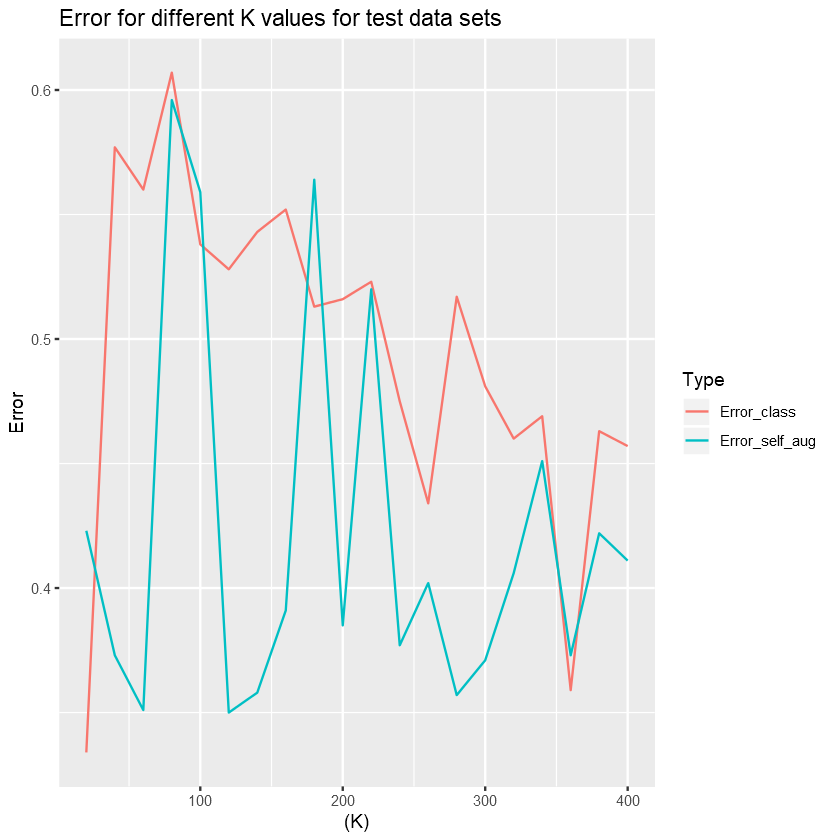

In [20]:
# plotting the train and test data error calculated for different K-Values(1 to 30).

error_file_viz <- melt(total_error, id='K') # reshaping for visualization

names(error_file_viz) <- c('K', 'Type', 'Error') #rename the columns being reshaped

#Plotting the error graph
ggplot(data=error_file_viz, aes(x=(K), y=Error, color=Type)) + geom_line() + ggtitle("Error for different K values for test data sets")

**Inference** : As K values increases the error values decreases with huge fluctuations and comparing the 3-layer neural network and augmented self-taught network, we could say that the error rate for 3 layer neural network is higher than the augmented self-taught network and converges that is because augmented self-taught networks has more features (original + extra) which improvises the model and decreases the error.